In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

## Definition of the `Value` class 

The `Value` class implements the data structure necessary to support the mathematical expressions underpinning neural networks

In [2]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data ** (other -1)) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): #-self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        t = math.tanh(self.data)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2)*out.grad
        out._backward = _backward
        
        return out 

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

## GraphViz function

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    # for n in nodes:
    #     dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
    #     if n._op:
    #         dot.node(name=str(id(n)) + n._op, label=n._op)
    #         dot.edge(str(id(n)) + n._op, str(id(n)))
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

We can call `draw_dot` on some root node and visualize it.

## Develop

In the graphs we visualize every data and every operation that's carried from the inputs the output. All that information is contained in the `Value` objects and must be calculated.

In [4]:
import random

In [78]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params=[]
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def zero_grad(self):
        for p in self.parameters():
            p.grad=0

    def update_params(self, learning_rate:float = 0.05):
        for p in self.parameters():
            p.data += -learning_rate * p.grad

    def training_loop(self, X, y, epochs = 10, learning_rate = 0.05):
        print(epochs)
        epoch_loss = []
        for i in range(epochs):
            ypred = [self.__call__(x) for x in X]
            loss = sum([(yout-ygt)**2 for ygt, yout in zip(y, ypred)])
            epoch_loss.append(loss.data)
            if i%10 ==0:
                print(f'Epoch {i} | Loss {loss.data}')
            self.zero_grad()
            loss.backward()
            self.update_params(learning_rate)
        print(f'Epoch {i} | Loss {loss}')

        plt.plot(epoch_loss)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        # return epoch_loss
        

In [48]:
mlp = MLP(3, [4, 4, 1])
# x=[2.0, 3.0, -1.0]
# o = mlp(x)

In [49]:
len(mlp.parameters())

41

In [50]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

10
Epoch 0 | Loss 6.298350531892535
Epoch 9 | Loss Value(data=0.040814397238130545)


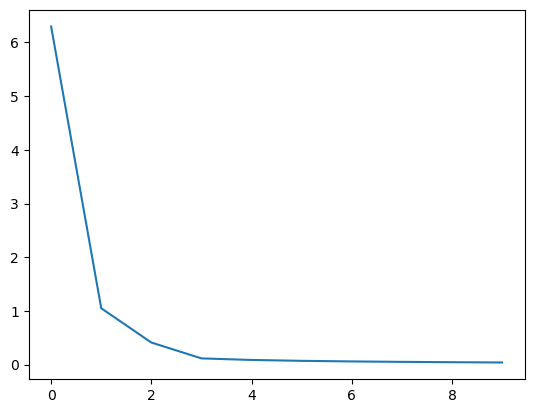

In [51]:
mlp.training_loop(xs, ys, 10, 0.1)

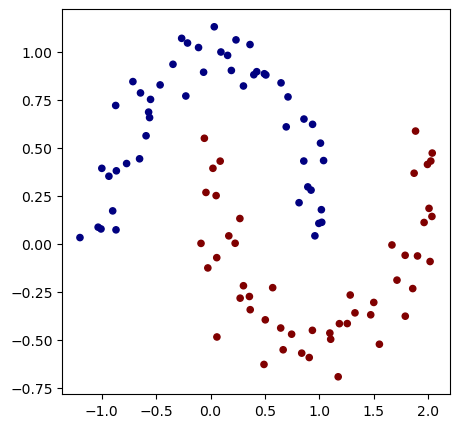

In [67]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet');

In [68]:
y

array([-1,  1, -1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1,  1,  1,  1,
        1,  1, -1,  1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1,
       -1,  1,  1, -1, -1, -1,  1, -1, -1, -1,  1,  1, -1, -1,  1,  1, -1,
       -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,
       -1, -1, -1,  1, -1,  1, -1,  1,  1,  1, -1, -1, -1,  1,  1, -1, -1,
        1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1, -1])

In [76]:
model = MLP(2, [2,1])

100
Epoch 0 | Loss 193.6351993780172
Epoch 10 | Loss 95.80548469328744
Epoch 20 | Loss 38.505935419475286
Epoch 30 | Loss 35.39490628732693
Epoch 40 | Loss 35.09286264101859
Epoch 50 | Loss 35.020622004143476
Epoch 60 | Loss 34.98523112276997
Epoch 70 | Loss 34.957541453213544
Epoch 80 | Loss 34.93196313338826
Epoch 90 | Loss 34.90729748314836
Epoch 99 | Loss Value(data=34.885621181965114)


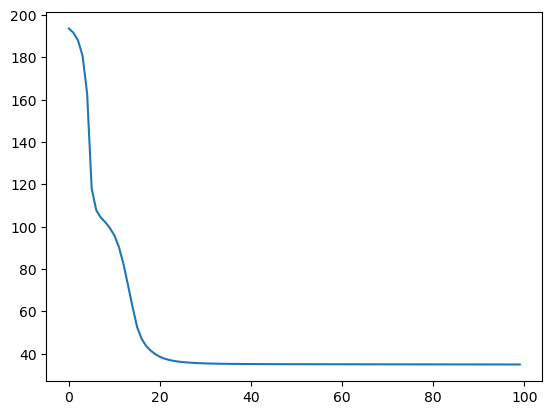

In [77]:
model.training_loop(X, y, 100, 0.005)